In [11]:
%pip install importnb

Note: you may need to restart the kernel to use updated packages.


In [12]:
from importnb import Notebook
import PDSVRP_instance
import time
import pandas as pd
import os

with Notebook():
    from solver import PDSVRPModel
    import heuristic as h
    import utilities as u

In [13]:
def run_scalability_tests(solver, heuristic, instances, sigma, w1, w2, w3, w4, w5, gamma, n_nearest, delta, epsilon, iter_imp, iter_max, p_min, max_unfeasible_swaps_perturb):
    results = []

    for instance_name in instances:
        if ("20-" in instance_name or "10-" in instance_name):
            instance = PDSVRP_instance.PDSVRPInstance("instances/small_instances/" + instance_name + ".txt") # Assumi che le istanze abbiano una rappresentazione stringa unica
        else:
            instance = PDSVRP_instance.PDSVRPInstance("instances/" + instance_name + ".txt")

        c_average_removed = instance.N * 0.15
        L_max = instance.N * 0.15
        p_min_adapted = (int) (min (p_min, instance.N * 0.1))
        p_max = (int) (instance.N * 0.1)
        

        s = solver(instance) 
        s.build_model()
        s.solve()
        cost_solver = s.model.objVal
        elapsed_time_solver = s.model.Runtime


        print("Heuristic") 
        start_time = time.time()
        sol = heuristic(instance, sigma, c_average_removed, L_max, w1, w2, w3, w4, w5, gamma, n_nearest, delta, epsilon, iter_imp, iter_max, p_min_adapted, p_max, max_unfeasible_swaps_perturb)
        end_time = time.time()
        cost_heu = u.cost(instance, sol)
        cost_difference = ((cost_heu - cost_solver) / cost_solver) * 100
        elapsed_time_heuristic = end_time - start_time
        print("Cost found with heuristic: ", cost_heu)

        results.append({
            "instance": instance_name,
            "cost_solver": cost_solver,
            "cost_heuristic": cost_heu,
            "cost_difference_percentage": cost_difference,
            "time_solver": elapsed_time_solver,
            "time_heuristic": elapsed_time_heuristic,

            "iter_imp": iter_imp,
            "iter_max": iter_max

        })
    
    return results

In [14]:
def save_results_to_csv(results, filename):
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)    

In [15]:
instances = []
for n_customers in ["10", "20", "30", "50"]:
    for customers_position in ["c", "r", "rc"]:
        for depot_position in ["c", "e", "r"]:
            instances.append(n_customers + "-" + customers_position + "-1-" + depot_position)

model = PDSVRPModel
heuristic = h.SISSRs

results = run_scalability_tests(model, heuristic, instances, 0.3, 5,1,1,2,2, 0.1, 20, 0.1, 0.999975, 100, 1000, 3, 9)
save_results_to_csv(results, "results/scalability_results.csv")

Set parameter Threads to value 8
Set parameter MIPFocus to value 1
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 146 rows, 270 columns and 1004 nonzeros
Model fingerprint: 0xfe1b8803
Variable types: 120 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+03]
  Objective range  [1e-01, 4e+01]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 15.1048282
Presolve removed 55 rows and 145 columns
Presolve time: 0.01s
Presolved: 91 rows, 125 columns, 582 nonzeros
Variable types: 61 continuous, 64 integer (64 binary)
Root relaxation presolve removed 1 rows and 0 columns
R

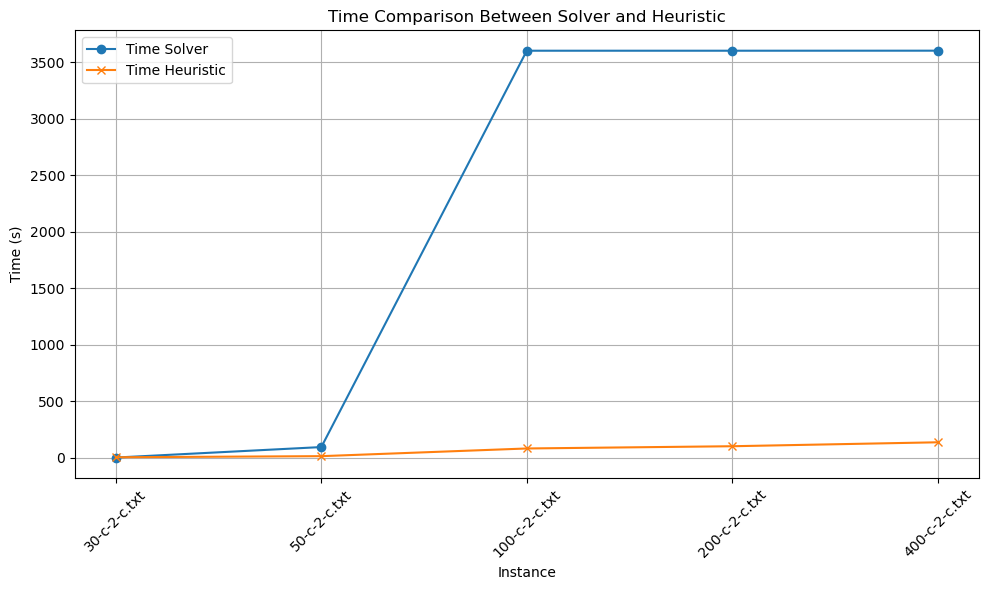

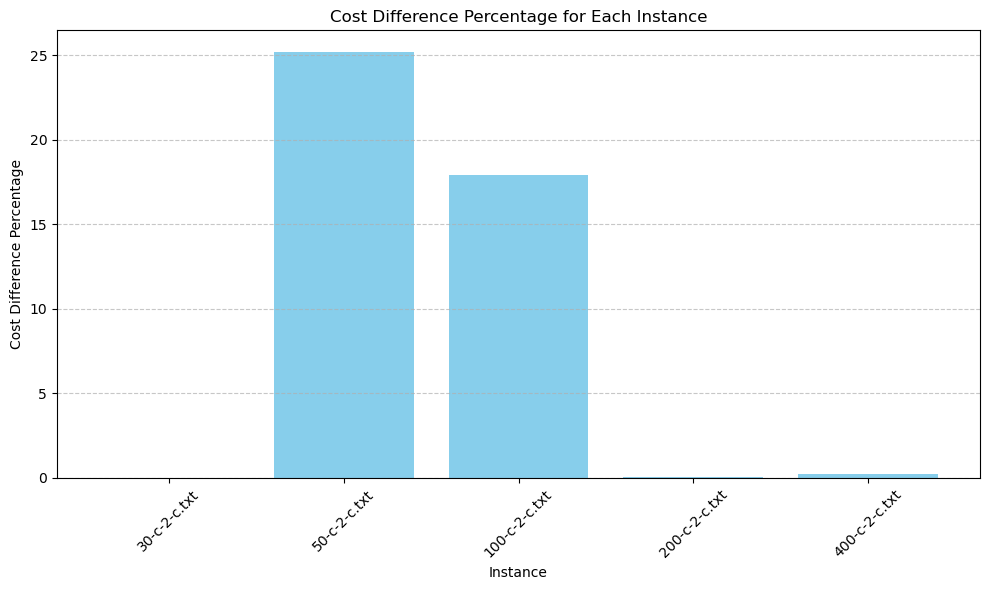

In [3]:
import matplotlib.pyplot as plt

df = pd.read_csv('./results/scalability_analisys_results_c-c.csv')
results = df.to_dict(orient='records')
results.insert(0, results.pop(2))
results.insert(1, results.pop(4))


# Extracting data
instances = [result["instance"] for result in results]
time_solver = [result["time_solver"] for result in results]
time_heuristic = [result["time_heuristic"] for result in results]
cost_difference_percentage = [result["cost_difference_percentage"] for result in results]


# Plotting
plt.figure(figsize=(10, 6))

plt.plot(instances, time_solver, label='Time Solver', marker='o')
plt.plot(instances, time_heuristic, label='Time Heuristic', marker='x')

plt.xlabel('Instance')
plt.ylabel('Time (s)')
plt.title('Time Comparison Between Solver and Heuristic')
plt.legend()
plt.xticks(rotation=45)  # Rotate instance names if they are too long
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for labels

# Show plot
plt.show()

# Plotting histogram
plt.figure(figsize=(10, 6))

plt.bar(instances, cost_difference_percentage, color='skyblue')

plt.xlabel('Instance')
plt.ylabel('Cost Difference Percentage')
plt.title('Cost Difference Percentage for Each Instance')
plt.xticks(rotation=45)  # Rotate instance names if they are too long
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to make room for labels

# Show plot
plt.show()
